### Importing Libraries
Import the required libraries for data analysis.

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader

import snntorch as snn
from snntorch import utils
from snntorch import surrogate
from snntorch import functional as SF

In [2]:
class GraphDataset(Dataset):
    FILE_PATH = ''
    
    def __init__(self, user_id=None, label_list=None, num_samples=None, secs=None):
        self.user_id = user_id
        self.label_list = label_list
        self.num_samples = num_samples
        self.secs = secs
        
        self.data, self.labels = self.load_data(user_id, label_list, secs)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.Tensor(self.data[idx]), self.labels[idx]
    
    def load_data(self, user_id, label_list, secs):
        data = list()
        labels = list()
        
        for i in range(len(label_list)):
            for j in range(1, num_samples + 1):
                try:
                    adjMatrix = scipy.io.loadmat(
                        self.FILE_PATH + str(user_id) +
                        '_label' + str(label_list[i]) +
                        '_item' + str(j) + '.mat')
                    
                except Exception as e:
                    print(f"Load fail: {e}")
                    continue
                    
                if self.secs == 1:
                    tmpAdjMatrix = adjMatrix['fullMatrix'][np.newaxis, :, :]
                else:
                    tmpAdjMatrix = list()
                    for k in range(self.secs):
                        tmpAdjMatrix.append(adjMatrix['fullMatrix'][:, :, k])
                                        
                data.append(np.array(tmpAdjMatrix))
                labels.append(label_list[i])
                                
        if not data or not labels:
            raise RuntimeError("No data or labels loaded.")
                    
        data = torch.tensor(np.stack(data), dtype=torch.float32)
                
        label_dict = {label: index for index, label in enumerate(self.label_list)}
        new_label_list = [label_dict[label] for label in labels]
        labels = torch.tensor(new_label_list, dtype=torch.long)
        
        return data, labels

### Loading Data
Load the full dataset.

In [3]:
user_id = 5
label_list = [769, 772]
num_samples = 72
secs = 1

In [4]:
full_dataset = GraphDataset(user_id=user_id, label_list=label_list, num_samples=num_samples, secs=secs)

Create the train and test set.

In [5]:
train_size = int(0.75 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [6]:
batch_size = 6

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Classification

In [7]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [8]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.9
num_steps = 25

In [9]:
net = nn.Sequential(
    nn.Conv2d(1, 32, 5),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, learn_threshold=True),
    nn.Conv2d(32, 64, 5),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, learn_threshold=True),
    nn.Flatten(),
    nn.Linear(64 * 2 * 2, len(label_list)),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, learn_threshold=True, output=True)
)

In [10]:
class SCNN(nn.Module):
    def __init__(self, label_list):
        super(SCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.norm1 = nn.BatchNorm2d(6)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.norm2 = nn.BatchNorm2d(16)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.dropout1 = nn.Dropout(0.5)
        self.pool1 = nn.AvgPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(16, 16, kernel_size=5)
        self.norm3 = nn.BatchNorm2d(16)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.dropout2 = nn.Dropout(0.5)
        self.pool2 = nn.AvgPool2d(2, 2)

        self.dropout3 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(144, len(label_list))
        self.lif4 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        
        cur1 = self.norm1(self.conv1(x))
        spk1, mem1 = self.lif1(cur1, mem1)
        
        cur2 = self.norm2(self.conv2(spk1))
        spk2, mem2 = self.lif2(cur2, mem2)
        x = self.dropout1(spk2)
        x = self.pool1(x)

        cur3 = self.norm3(self.conv3(x))
        spk3, mem3 = self.lif3(cur3, mem3)
        x = self.dropout2(x)
        x = self.pool2(x)
        
        x = torch.flatten(x, 1)
        
        x = self.dropout3(x)
        
        cur4 = self.fc1(x)
        spk4, mem4 = self.lif4(cur4, mem4)

        return spk4, mem4

In [11]:
net = SCNN(label_list).to(device)

In [12]:
def forward_pass(net, num_steps, data):
    mem_rec = []
    spk_rec = []
    utils.reset(net)  # resets hidden states for all LIF neurons in net
    
    for step in range(num_steps):
        spk_out, mem_out = net(data)
        spk_rec.append(spk_out)
        mem_rec.append(mem_out)
        
    return torch.stack(spk_rec), torch.stack(mem_rec)

In [13]:
# already imported snntorch.functional as SF 
loss_fn = SF.ce_rate_loss()

In [14]:
def batch_accuracy(train_loader, net, num_steps):
    with torch.no_grad():
        total = 0
        acc = 0
        net.eval()
        
    train_loader = iter(train_loader)
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)
        spk_rec, _ = forward_pass(net, num_steps, data)
        
        acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
        total += spk_rec.size(1)
    
    return acc/total

In [15]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 200
loss_hist = []
test_acc_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):

    # Training loop
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        if counter % 50 == 0:
            with torch.no_grad():
                net.eval()
                
                # Test set forward pass
                test_acc = batch_accuracy(test_loader, net, num_steps)
                print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
                test_acc_hist.append(test_acc.item())

        counter += 1

Iteration 0, Test Acc: 55.56%

Iteration 50, Test Acc: 55.56%

Iteration 100, Test Acc: 55.56%

Iteration 150, Test Acc: 55.56%

Iteration 200, Test Acc: 55.56%

Iteration 250, Test Acc: 55.56%

Iteration 300, Test Acc: 55.56%

Iteration 350, Test Acc: 55.56%

Iteration 400, Test Acc: 55.56%

Iteration 450, Test Acc: 55.56%

Iteration 500, Test Acc: 55.56%

Iteration 550, Test Acc: 55.56%

Iteration 600, Test Acc: 55.56%

Iteration 650, Test Acc: 58.33%

Iteration 700, Test Acc: 61.11%

Iteration 750, Test Acc: 55.56%

Iteration 800, Test Acc: 61.11%

Iteration 850, Test Acc: 69.44%

Iteration 900, Test Acc: 63.89%

Iteration 950, Test Acc: 69.44%

Iteration 1000, Test Acc: 63.89%

Iteration 1050, Test Acc: 63.89%

Iteration 1100, Test Acc: 58.33%

Iteration 1150, Test Acc: 58.33%

Iteration 1200, Test Acc: 58.33%

Iteration 1250, Test Acc: 63.89%

Iteration 1300, Test Acc: 55.56%

Iteration 1350, Test Acc: 63.89%

Iteration 1400, Test Acc: 63.89%

Iteration 1450, Test Acc: 63.89%

Ite

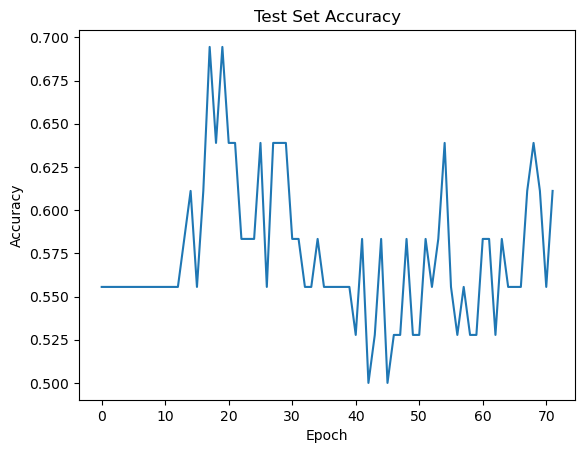

In [16]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()